## weight-tuning_EB_LG
*   Epoch Bound : 在train 4000中
*   Learning Goal : loss要小於0.25

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Load the Boston Housing dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/新型學習演算法/diabetes.csv')
print("dimension of data: {}".format(data.shape))

dimension of data: (768, 9)


In [ ]:
X = data.drop('Outcome',axis = 1)
X = X.values
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
# 將數據轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

In [ ]:
# 設定參數
D_in = X.shape[1]
H = 7
D_out = 1
print(f'Input layer: {D_in}')

# learning rate
learning_rate = 0.01

# learning goal
lg = 0.42

epoch_bound = 100

Input layer: 8


In [ ]:
from collections import OrderedDict
# Define 2-layer neural network
model_EB_LG = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(D_in, H)),
    ('relu', torch.nn.ReLU()),
    ('output', torch.nn.Linear(H, D_out))
])
)

In [ ]:
import time
# 損失函數和learning rate
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification without sigmoid
optimizer = optim.Adam(model_EB_LG.parameters(), lr=learning_rate)

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []

# Train the network
loss = float('Inf')

best_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter for early stopping

start_time = time.time()

for epoch in range(epoch_bound):
  if loss > lg:
    output = model_EB_LG(X_train)
    loss = criterion(output.view(-1), y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation phase
    model_EB_LG.eval()
    with torch.no_grad():
      val_outputs = model_EB_LG(X_val)
      val_loss = criterion(val_outputs.view(-1), y_val)

    scheduler.step()

    # Collect the training loss values in list
    train_losses.append(loss.item())

    # Check for early stopping
    if val_loss < best_loss:
      best_loss = val_loss
      counter = 0
    else:
      counter += 1
      if counter >= patience:
        print("Early stopping. No improvement for {} epochs.".format(patience))
        break
  else:
    break


end_time = time.time()
duration = round(end_time - start_time, 3)
print(f"Training took {duration} seconds.")
print()
if epoch+1 < epoch_bound:
  print('Acceptable, Epoch {}, Loss: {}'.format(epoch+1, loss.item()))
else:
  print('Unacceptable, reach epochs {} but loss > {}.\nEpoch {}, Loss: {}'.format(epoch_bound, lg, epoch+1, loss.item()))



Early stopping. No improvement for 5 epochs.
Training took 0.164 seconds.

Acceptable, Epoch 40, Loss: 4.337043285369873


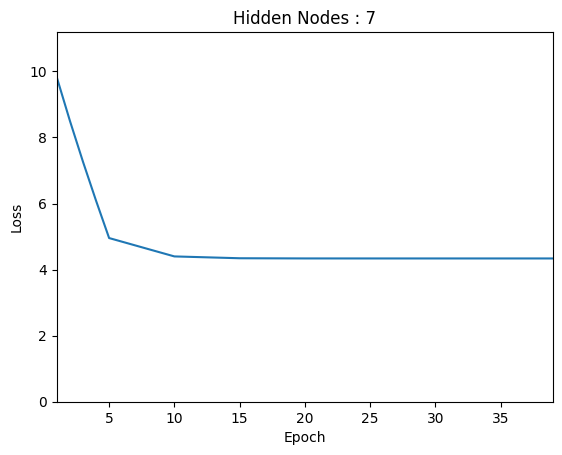

In [ ]:
# Plot the loss curve
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.title(f'Hidden Nodes : {H}')
plt.xlim(1, epoch)
plt.ylim(0, max(train_losses))
plt.show()

In [ ]:
y_pred = model_EB_LG(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = torch.round(torch.sigmoid(y_pred))

# Calculate accuracy
total = len(y_test)
correct = 0
for i in range(len(y_pred_labels)):
  if y_pred_labels[i] == y_test[i]:
    correct += 1
accuracy = round((correct / total) * 100,2)

print(f"Accuracy: {accuracy}%")

Accuracy: 38.31%


## Load Pre-processing data

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/新型學習演算法/preprocess.pkl')

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.494673,120.894531,69.105469,29.153420,155.548223,31.992578,0.471876,33.240885,0.348958
std,2.975395,31.972618,19.355807,8.790942,85.021108,7.884160,0.331329,11.760232,0.476951
min,1.000000,0.000000,0.000000,7.000000,14.000000,0.000000,0.078000,21.000000,0.000000
25%,2.000000,99.000000,62.000000,25.000000,121.500000,27.300000,0.243750,24.000000,0.000000
50%,4.494673,117.000000,72.000000,29.153420,155.548223,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Outcome',axis = 1))
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
# 將數據轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

In [ ]:
from collections import OrderedDict
# Define 2-layer neural network
model_EB_LG = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(D_in, H)),
    ('relu', torch.nn.ReLU()),
    ('output', torch.nn.Linear(H, D_out))
])
)

# 損失函數和learning rate
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification without sigmoid
optimizer = optim.Adam(model_EB_LG.parameters(), lr=learning_rate)

train_losses = []

# Train the network
loss = float('Inf')
best_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter for early stopping
start_time = time.time()
for epoch in range(epoch_bound):
  if loss > lg:

    output = model_EB_LG(X_train)
    loss = criterion(output.view(-1), y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation phase
    model_EB_LG.eval()
    with torch.no_grad():
      val_outputs = model_EB_LG(X_val)
      val_loss = criterion(val_outputs.view(-1), y_val)

    scheduler.step()


    # Collect the training loss values in list
    train_losses.append(loss.item())

    # Check for early stopping
    if val_loss < best_loss:
      best_loss = val_loss
      counter = 0
    else:
      counter += 1
      if counter >= patience:
        print("Early stopping. No improvement for {} epochs.".format(patience))
        break
  else:
    break


end_time = time.time()
duration = round(end_time - start_time, 3)
print(f"Training took {duration} seconds.")
print()
if epoch+1 < epoch_bound and loss < lg:
  print('Acceptable, Epoch {}, Loss: {}'.format(epoch+1, loss.item()))
else:
  print('Unacceptable, reach epochs {} but loss > {}.\nEpoch {}, Loss: {}'.format(epoch_bound, lg, epoch+1, loss.item()))



Early stopping. No improvement for 5 epochs.
Training took 0.214 seconds.

Unacceptable, reach epochs 100 but loss > 0.42.
Epoch 62, Loss: 0.4397980570793152


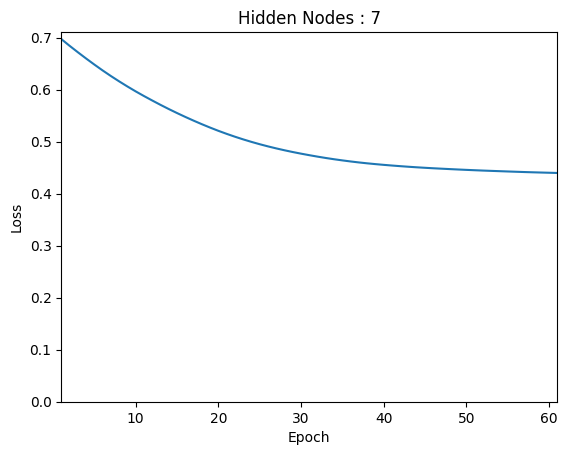

In [ ]:
# Plot the loss curve
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.title(f'Hidden Nodes : {H}')
plt.xlim(1, epoch)
plt.ylim(0, max(train_losses))
plt.show()

In [ ]:
y_pred = model_EB_LG(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = torch.round(torch.sigmoid(y_pred))

# Calculate accuracy
total = len(y_test)
correct = 0
for i in range(len(y_pred_labels)):
  if y_pred_labels[i] == y_test[i]:
    correct += 1
accuracy = round((correct / total) * 100,2)

print(f"Accuracy: {accuracy}%")

Accuracy: 75.32%


## Find unacceptable cases
Two-class classification application
Use learing_goal_2 :


1.   If f(x,w) ≥ 𝛆, label=1
2.   If f(x,w) ≤ -𝛆, label=0
3.   If 𝛆 < f(x,w) < 1-𝛆, then x unknown



In [ ]:
𝛆 = 2.5
acceptable = []
unacceptable = []
acceptable_idx = []
unacceptable_idx = []
unknown = []
unknown_idx = []
for i in range(len(X_train)):
  output = model_EB_LG(X_train[i])
  if output >= 𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  elif output <= -𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  else:
    unknown.append(X_train[i])
    unknown_idx.append(i)
print(len(unacceptable))

1


In [ ]:
unacceptable_idx

[55]

In [ ]:
len(X_train) == len(unknown)+len(acceptable)+len(unacceptable)

True

In [ ]:
len(unknown)

384

## Isolating_Ri_ZG

In [ ]:
# random generate gama (8-dimensional tensor)
𝛾 = np.random.rand(8)
k = unacceptable[0]
for i in acceptable:
  if np.dot(𝛾, (i-k)) == 0:
    print('unacceptable 𝛾')
    break
print(f'This 𝛾={𝛾} is acceptable')

This 𝛾=[0.83219893 0.3995828  0.4662331  0.26999288 0.58892512 0.57022492
 0.81863109 0.78061715] is acceptable


In [ ]:
type(𝛾)

numpy.ndarray

In [ ]:
import random
random_float = random.uniform(0, 1)
print(random_float)

0.6270298843143124


In [ ]:
import random
flag = 1
while flag == 1:
  𝜁 = random.uniform(0, 1)
  for i in acceptable:
    if (𝜁 + np.dot(𝛾, (i-k)))*(𝜁 - np.dot(𝛾, (i-k))) >= 0:
      '''print('unacceptable 𝜁')'''
      break
    if i.tolist() == acceptable[-1].tolist():
      print(f'This 𝜁={𝜁} is acceptable')
      flag = 0

This 𝜁=0.26957844747868753 is acceptable


In [ ]:
Analogizing_loss = []

## 看要改幾個unacceptable case才可以達到learning goal

In [ ]:
while len(unacceptable_idx) > 0:
  for i in range(0,1):
    # 從第一個unacceptable case開始修正
    new_node_weights = 𝛾 # 初始化input to hidden nodes的weights
    new_node_bias_1 = 𝜁 - np.dot(𝛾, unacceptable[i])
    new_node_bias_2 = -np.dot(𝛾, unacceptable[i])
    new_node_bias_3 = -𝜁 - np.dot(𝛾, unacceptable[i])
    # activation of i hidden node corresponding to x_k
    hidden_layer_value = torch.matmul(unacceptable[0], model_EB_LG.fc1.weight.T)
    hidden_layer_Relu = torch.where(hidden_layer_value >= 0, hidden_layer_value, torch.zeros_like(hidden_layer_value)) # ReLU
    new_node_output_weights_1 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
    new_node_output_weights_2 = (-2*(y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T)))/𝜁
    new_node_output_weights_3 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
    '''print(new_node_weights)
    print(new_node_bias)
    print(new_node_output_weights)'''

    # 手動新增hidden node按照數學公式
    hidden_layer_params = model_EB_LG.fc1.weight.detach().numpy()
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    '''print(hidden_layer_params)'''
    bias_matrix = model_EB_LG.fc1.bias.detach().numpy()
    new_bias = np.append(bias_matrix, new_node_bias_1)
    new_bias = np.append(new_bias, new_node_bias_2)
    new_bias = np.append(new_bias, new_node_bias_3)
    '''print(new_bias)'''
    weight_matrix_2 = model_EB_LG.output.weight.detach().numpy()
    modified_weight_matrix_2 = np.append(weight_matrix_2[0], new_node_output_weights_1)
    modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_2)
    modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_3)
    # Get the number of hidden nodes in the second layer
    h = model_EB_LG.fc1.bias.shape
    updated_weight_matrix_2 = np.empty((1,h[0]+(i+1)*3))
    updated_weight_matrix_2[0] = modified_weight_matrix_2
    '''print(updated_weight_matrix_2)'''
    # 將自訂的權重和偏差儲存在模型中
    model_EB_LG.fc1.weight = nn.Parameter(torch.from_numpy(hidden_layer_params).type(torch.Tensor))
    model_EB_LG.fc1.bias = nn.Parameter(torch.from_numpy(new_bias).type(torch.Tensor))
    model_EB_LG.output.weight = nn.Parameter(torch.from_numpy(updated_weight_matrix_2).type(torch.Tensor))

    print(f'調整第{i+1}個unacceptable case後的parameters setting')
    for name, param in model_EB_LG.named_parameters():
      print(name, param)
    output = model_EB_LG(X_train)
    loss = criterion(output.view(-1), y_train)
    print()
    print('loss = {}'.format(loss))
    Analogizing_loss.append(loss)
    print('==========================================================================')

    if loss <= lg:
      print('Acceptable model')
      break
    else:
      print('Fail')

    acceptable = []
    unacceptable = []
    acceptable_idx = []
    unacceptable_idx = []
    unknown = []
    unknown_idx = []
    for i in range(len(X_train)):
      output = model_EB_LG(X_train[i])
      if output >= 𝛆:
        if torch.round(torch.sigmoid(output)) == y_train[i]:
          acceptable.append(X_train[i])
          acceptable_idx.append(i)
        else:
          unacceptable.append(X_train[i])
          unacceptable_idx.append(i)
      elif output <= -𝛆:
        if torch.round(torch.sigmoid(output)) == y_train[i]:
          acceptable.append(X_train[i])
          acceptable_idx.append(i)
        else:
          unacceptable.append(X_train[i])
          unacceptable_idx.append(i)
      else:
        unknown.append(X_train[i])
        unknown_idx.append(i)
    print('unacceptable cases count:',len(unacceptable))
    print(unacceptable_idx)
    print()

調整第1個unacceptable case後的parameters setting
fc1.weight Parameter containing:
tensor([[-0.2202,  0.8421, -0.3047, -0.2078, -0.3908,  0.4071,  0.0357, -0.0709],
        [-0.0517,  0.2267, -0.1513,  0.0135, -0.0329, -0.0200,  0.2447,  0.4136],
        [-0.0704, -0.5538,  0.1623, -0.0109, -0.3716, -0.0025, -0.3576, -0.3580],
        [ 0.5153,  0.6486, -0.3111, -0.2542, -0.2175,  0.5763, -0.0547, -0.3356],
        [-0.6824, -0.2348, -0.1100, -0.6780, -0.0060, -0.5971, -0.3518, -0.4702],
        [ 0.1618,  0.5761,  0.0137, -0.0728, -0.0868,  0.3116,  0.1950,  0.0009],
        [ 0.0895,  0.1905,  0.0289,  0.1407,  0.0388, -0.1343, -0.0327, -0.0924],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806]],
       requires_grad=True)
fc1.bias Parameter containing:
tensor([ 0.3578,  0.1531,  0.7548,  0.5452,  

## Retrain the model

In [ ]:

train_losses = []

# Train the network
loss = float('Inf')
best_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter for early stopping
start_time = time.time()
for epoch in range(epoch_bound):
  if loss > lg:

    output = model_EB_LG(X_train)
    loss = criterion(output.view(-1), y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation phase
    model_EB_LG.eval()
    with torch.no_grad():
      val_outputs = model_EB_LG(X_val)
      val_loss = criterion(val_outputs.view(-1), y_val)

    scheduler.step()


    # Collect the training loss values in list
    train_losses.append(loss.item())

    # Check for early stopping
    if val_loss < best_loss:
      best_loss = val_loss
      counter = 0
    else:
      counter += 1
      if counter >= patience:
        print("Early stopping. No improvement for {} epochs.".format(patience))
        break
  else:
    break


end_time = time.time()
duration = round(end_time - start_time, 3)
print(f"Training took {duration} seconds.")
print()
if epoch+1 < epoch_bound and loss < lg:
  print('Acceptable, Epoch {}, Loss: {}'.format(epoch+1, loss.item()))
else:
  print('Unacceptable, reach epochs {} but loss > {}.\nEpoch {}, Loss: {}'.format(epoch_bound, lg, epoch+1, loss.item()))



Early stopping. No improvement for 5 epochs.
Training took 0.024 seconds.

Unacceptable, reach epochs 100 but loss > 0.42.
Epoch 19, Loss: 0.4394673705101013


## Network-tuning

In [ ]:
torch.save(model_EB_LG, 'Acc_SLFN.pt') # 存下 weight-tuning_LG_UA 的所有參數，當作 network-tuning 的 Acceptable SLFN

In [ ]:
import numpy as np
model_1 = torch.load('Acc_SLFN.pt')

p = model_1.fc1.bias.shape[0]
k = 1
count = 0
while k <= p:
  torch.save(model_1, 'temp.pt')
  # Get the weight matrix of the first linear layer of the model
  weight_matrix = model_1.fc1.weight.detach().numpy()
  # Delete the k-th row from the weight matrix using NumPy's delete() function
  modified_weight_matrix = np.delete(weight_matrix, (k-1), axis=0)
  model_1.fc1.weight = nn.Parameter(torch.from_numpy(modified_weight_matrix).type(torch.Tensor))

  bias_matrix = model_1.fc1.bias.detach().numpy()
  modified_bias_matrix = np.delete(bias_matrix, k-1)
  model_1.fc1.bias = nn.Parameter(torch.from_numpy(modified_bias_matrix).type(torch.Tensor))

  weight_matrix_2 = model_1.output.weight.detach().numpy()
  modified_weight_matrix_2 = np.delete(weight_matrix_2, k-1, 1)
  model_1.output.weight = nn.Parameter(torch.from_numpy(modified_weight_matrix_2).type(torch.Tensor))

  output = model_1(X_train)
  w_loss = criterion(output.view(-1), y_train)
  w_loss.backward() # w的偏微分
  if w_loss > loss+0.1:
    print(f'\nRestore 第{count+1}個 hidden node, because it is an unacceptable SLFN')
    model_1 = torch.load('temp.pt')

    # regularizing
    optimizer.param_groups[0]['lr'] *= 0.7
    optimizer.step() # w'：w往偏微分的方向走一個step size
    print('Regularizing done.')
    k += 1
    count += 1
  else:
    print(f'\nDelete 第{count+1}個 hidden node, the loss = {w_loss:.4f}')
    print('Acceptable SLFN')
    # regularizing
    optimizer.param_groups[0]['lr'] *= 0.7
    optimizer.step() # w'：w往偏微分的方向走一個step size
    print('Regularizing done.')
    p -= 1
    count += 1


Delete 第1個 hidden node, the loss = 0.4588
Acceptable SLFN
Regularizing done.

Delete 第2個 hidden node, the loss = 0.4580
Acceptable SLFN
Regularizing done.

Delete 第3個 hidden node, the loss = 0.4980
Acceptable SLFN
Regularizing done.

Delete 第4個 hidden node, the loss = 0.5362
Acceptable SLFN
Regularizing done.

Restore 第5個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第6個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Delete 第7個 hidden node, the loss = 0.5367
Acceptable SLFN
Regularizing done.

Restore 第8個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第9個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第10個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第11個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第12個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第13個 hidden node, because it is an una

## Accuracy after network-tuning

In [ ]:
y_pred = model_1(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = torch.round(torch.sigmoid(y_pred))

# Calculate accuracy
total = len(y_test)
correct = 0
for i in range(len(y_pred_labels)):
  if y_pred_labels[i] == y_test[i]:
    correct += 1
accuracy = round((correct / total) * 100,2)

print(f"Accuracy: {accuracy}%")

Accuracy: 68.18%


In [ ]:
for name, param in model_1.named_parameters():
    print(name, param)

fc1.weight Parameter containing:
tensor([[-0.6824, -0.2348, -0.1100, -0.6780, -0.0060, -0.5971, -0.3518, -0.4702],
        [ 0.1618,  0.5761,  0.0137, -0.0728, -0.0868,  0.3116,  0.1950,  0.0009],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806],
        [ 0.8322,  0.3996,  0.4662,  0.2700,  0.5889,  0.5702,  0.8186,  0.7806]],
       requires_grad=True)
fc1.bias Parameter containing:
tensor([ 0.3722, -0.2972, -1.8218, -2.0914, -2.3610, -1.7453, -2.0149, -2.2845],
       requires_grad=True)
output.weight Parameter containing:
tensor([[ -0.7096,   0.4824,  -8.3849,  16.7699,  -8.3849,   5.9298, -11.8595,
           5.9298]], requires